In [327]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import log_loss
from sklearn.neighbors import RadiusNeighborsClassifier
import scipy
np.random.seed(0)

# Part 1.1
Naive instance space. We will initially fix the time series length to a large value (5000) and noise to a low value (0.01) to build intuition.

Regenerate original plots for naive instance space

In [83]:
catch22_feature_names = ["DN_HistogramMode_5", "DN_HistogramMode_10", "CO_f1ecac", "CO_FirstMin_ac", "CO_HistogramAMI_even_2_5", "CO_trev_1_num", 
                            "MD_hrv_classic_pnn40", "SB_BinaryStats_mean_longstretch1", "SB_TransitionMatrix_3ac_sumdiagcov", 
                            "PD_PeriodicityWang_th0_01", "CO_Embed2_Dist_tau_d_expfit_meandiff", 
                            "IN_AutoMutualInfoStats_40_gaussian_fmmi", "FC_LocalSimple_mean1_tauresrat", 
                            "DN_OutlierInclude_p_001_mdrmd", "DN_OutlierInclude_n_001_mdrmd", "SP_Summaries_welch_rect_area_5_1", 
                            "SB_BinaryStats_diff_longstretch0", "SB_MotifThree_quantile_hh", "SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1", 
                            "SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1", "SP_Summaries_welch_rect_centroid", "FC_LocalSimple_mean3_stderr"]

In [2]:
def gen_bistable(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
    ic = np.array([np.random.uniform()])
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:] # exclude 500 samples for transients

In [97]:
def gen_hopf(eta, mu, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
    ic = np.array(np.random.uniform(size=2))
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:, 0] # only return x

In [349]:
def gen_hookes(mu, eta, N):
    dt = 0.01
    length = ((N+500)*dt)
    tspan = np.arange(0, length, dt)
    def f(state, t):
            x = state
            dxdt = -mu*x
            return dxdt
    ic = np.array(np.random.uniform(low=0, high=0.01, size=1))
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    return sol[500:]

In [300]:
def sample_hookes(n_samples, ns_val=None, etas_val=None):
    # set parameter ranges
    if ns_val is not None:
        ns = np.repeat(ns_val, n_samples)
    else:
        ns = np.random.randint(low=50, high=5000, size=n_samples)
    if etas_val is not None:
        etas = np.repeat(etas_val, n_samples)
    else:
        etas = np.random.uniform(low=0, high=1, size=n_samples)
    mus = np.random.uniform(low=0.01, high=5, size=n_samples)
    sols_list = list()

    # generate samples
    for i in range(n_samples):
        mu = mus[i]
        eta = etas[i]
        n = ns[i]
        sol = gen_hookes(eta, mu, n)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])

    # store results
    ts = sols_list
    df = pd.DataFrame(features, columns=catch22_feature_names)
    df['n'] = ns
    df['eta'] = etas
    df['mu'] = mus
    df['system'] = 'Hookes'
    return ts, df


In [301]:
def sample_hopf(n_samples, ns_val=None, etas_val=None):
    if ns_val is not None:
        ns = np.repeat(ns_val, n_samples)
    else:
        ns = np.random.randint(low=50, high=5000, size=n_samples)
    if etas_val is not None:
        etas = np.repeat(etas_val, n_samples)
    else:
        etas = np.random.uniform(low=0, high=1, size=n_samples)
    mus = np.random.uniform(low=-5, high=5, size=n_samples)
    sols_list = list()
    # generate instances
    for i in range(n_samples):
        mu = mus[i]
        eta = etas[i]
        n = ns[i]
        sol = gen_hopf(eta, mu, n)
        sols_list.append(sol)

    # extract features
    features = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])

    # store results
    ts = sols_list
    df = pd.DataFrame(features, columns=catch22_feature_names)
    df['n'] = ns
    df['eta'] = etas
    df['mu'] = mus
    df['system'] = 'Hopf'
    return ts, df
    

In [302]:
def sample_bistable(n_samples, ns_val=None, etas_val=None):
    if ns_val is not None:
        ns = np.repeat(ns_val, n_samples)
    else:
        ns = np.random.randint(low=50, high=5000, size=n_samples)
    if etas_val is not None:
        etas = np.repeat(etas_val, n_samples)
    else:
        etas = np.random.uniform(low=0, high=1, size=n_samples)
    mus = np.random.uniform(low=-1, high=1, size=n_samples)
    sols_list = list()
    
    # generate instances
    for i in range(n_samples):
        mu = mus[i]
        eta = etas[i]
        n = ns[i]
        sol = gen_bistable(eta, mu, n)
        sols_list.append(sol)

    # extract features
    features = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])

    # store results
    ts = sols_list
    df = pd.DataFrame(features, columns=catch22_feature_names)
    df['n'] = ns
    df['eta'] = etas
    df['mu'] = mus
    df['system'] = 'Bistable'
    return ts, df

In [326]:
# 1000 samples from each generative model, fix N and eta
ts_hopf, df_hopf = sample_hopf(10000, ns_val=5000, etas_val=0.01)
ts_bistable, df_bistable = sample_bistable(10000, ns_val=5000, etas_val=0.01)
ts_hookes, df_hookes = sample_hookes(10000, ns_val=5000, etas_val=0.01)

In [329]:
x = pd.concat([df_hopf, df_bistable, df_hookes], ignore_index=True)

In [330]:
ts = ts_hopf + ts_bistable + ts_hookes

In [345]:
rs_fit = RobustScaler().fit(x.iloc[:, :22])
rs = rs_fit.transform(x.iloc[:, :22])
def sigmoid(x, theta):
    return 1 / (1 + np.exp(-theta * x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_fit = sigmoid_transformer.fit(rs)
sig = sigmoid_fit.transform(rs)
mm_fit = MinMaxScaler().fit(sig)
mm = mm_fit.transform(sig)

In [346]:
pca_fit = PCA(n_components=2).fit(mm)
pca = pca_fit.transform(mm)

In [347]:
x['PC1'] = pca[:,0]
x['PC2'] = pca[:,1]

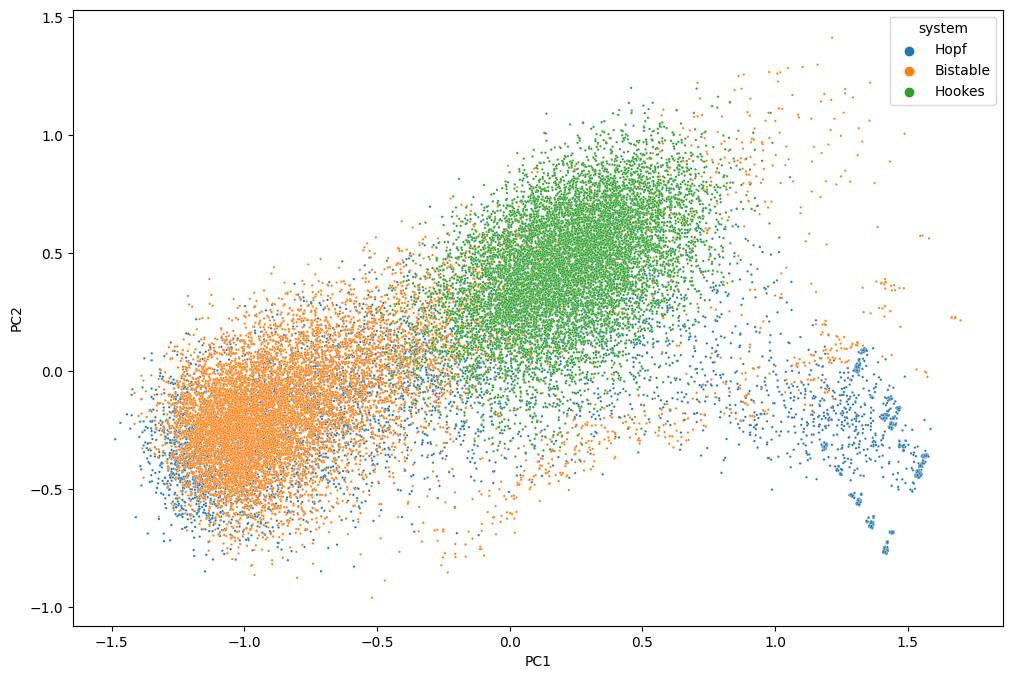

In [348]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=x, x='PC1', y='PC2', hue='system', s=3)
plt.show()

In [197]:
x[(x['PC1'] < 0.5) & (x['PC2'] < 0) & (x['system'] == 'Bistable')]

,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,...,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,n,eta,mu,system,PC1,PC2
5000,-0.740219,-0.480098,69.648426,214.0,0.757113,0.000344,0.819221,264.0,0.021915,426.0,...,0.795918,0.571429,0.013806,0.225637,2363,0.926476,-0.265223,Bistable,-0.029940,-0.003094
5001,-0.856905,-0.630982,171.934213,234.0,1.056266,-0.000017,0.692826,781.0,0.062500,0.0,...,0.244898,0.836735,0.004602,0.120954,2078,0.890641,0.084264,Bistable,-0.859345,-0.306008
5004,0.221255,0.969124,177.020196,435.0,0.838107,-0.000093,0.769835,277.0,0.005917,1021.0,...,0.326531,0.775510,0.006136,0.166043,3694,0.891109,0.437664,Bistable,-0.674088,-0.387093
5005,0.191260,0.431887,60.828461,93.0,0.788168,-0.000585,0.855118,125.0,0.111111,136.0,...,0.127660,0.148936,0.012272,0.245218,636,0.618255,-0.890993,Bistable,0.401612,-0.587812
5007,0.529948,1.053794,412.622900,942.0,1.179384,-0.000028,0.590824,780.0,0.111111,842.0,...,0.469388,0.795918,0.003068,0.090180,2682,0.671887,-0.475637,Bistable,-1.390512,-0.264006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987,-1.083385,-1.268775,108.553085,212.0,1.163960,-0.000145,0.700000,209.0,0.166667,0.0,...,0.173913,0.804348,0.012272,0.120332,481,0.522833,-0.419127,Bistable,-0.444621,-0.162480
9988,0.688997,0.892841,263.207917,606.0,1.092940,-0.000010,0.655837,744.0,0.086420,1132.0,...,0.204082,0.857143,0.004602,0.108072,4310,0.741555,-0.065839,Bistable,-1.253550,-0.408931
9995,-0.157265,-0.766595,403.759410,867.0,1.007189,-0.000002,0.578322,678.0,0.062500,897.0,...,0.795918,0.795918,0.003068,0.087756,2778,0.486494,-0.333336,Bistable,-1.342116,-0.130274
9997,0.557431,0.755145,567.870011,381.0,1.020202,0.000073,0.679309,542.0,0.111111,565.0,...,0.387755,0.122449,0.001534,0.117438,3244,0.875456,0.179644,Bistable,-1.036284,-0.619567


In [239]:
from sklearn.preprocessing import OneHotEncoder

In [233]:
model = RadiusNeighborsClassifier(radius=1, outlier_label='Outlier')
model.fit(xhat, x['system'])

RadiusNeighborsClassifier(outlier_label='Outlier', radius=1)

In [249]:
ts_val_hopf, df_val_hopf = sample_hopf(50)
ts_val_bistable, df_val_bistable = sample_bistable(50)
ts_val_hookes, df_val_hookes = sample_hookes(50)

In [251]:
df_val = pd.concat([df_val_hopf, df_val_bistable, df_val_hookes], ignore_index=True)

In [252]:
x_val = standardise.transform(df_val.iloc[:,:22])

In [254]:
y_prob = model.predict_proba(x_val)

In [257]:
print(y_prob)

[[0.09677419 0.04301075 0.86021505]
 [0.11669829 0.50891841 0.3743833 ]
 [0.11764706 0.5        0.38235294]
 [0.05221072 0.43932267 0.5084666 ]
 [0.         0.         1.        ]
 [0.00867052 0.         0.99132948]
 [0.08161474 0.41553313 0.50285213]
 [0.26678031 0.43724696 0.29597273]
 [0.13329519 0.57379863 0.29290618]
 [0.19761273 0.38969938 0.41268789]
 [0.00699301 0.03263403 0.96037296]
 [0.40034475 0.3697479  0.22990735]
 [0.0708921  0.43341271 0.49569518]
 [0.05626781 0.4045584  0.53917379]
 [0.13853904 0.7115869  0.14987406]
 [0.04199475 0.22834646 0.72965879]
 [0.06771697 0.4408513  0.49143173]
 [0.03580048 0.28841512 0.67578439]
 [0.36964897 0.33668664 0.29366438]
 [0.00212766 0.         0.99787234]
 [0.04633074 0.39634765 0.55732161]
 [0.06232295 0.45998584 0.47769122]
 [0.09527439 0.54077744 0.36394817]
 [0.00786627 0.02654867 0.96558505]
 [0.05637982 0.34836795 0.59525223]
 [0.06507372 0.44077275 0.49415353]
 [0.00220751 0.         0.99779249]
 [0.07294658 0.52929351 0.39

In [267]:
print(f"Log Loss: {log_loss(df_val['system'], y_prob)}")
print(f"Overall Classification Accuracy: {model.score(x_val, df_val['system'])}")


Log Loss: 0.6624758721191144
Overall Classification Accuracy: 0.74


In [293]:
epsilons = np.linspace(0.1, 1, 100)
accs = list()
losses = list()
for epsilon in epsilons:
    model = RadiusNeighborsClassifier(radius=epsilon, outlier_label='most_frequent')
    model.fit(xhat, x['system'])
    y_prob = model.predict_proba(x_val)
    accs.append(model.score(x_val, df_val['system']))
    losses.append(log_loss(df_val['system'], y_prob))
    #print(f"Epsilon: {epsilon} | Log Loss: {log_loss(df_val['system'], y_prob)} | Overall Classification Accuracy: {model.score(x_val, df_val['system'])}")


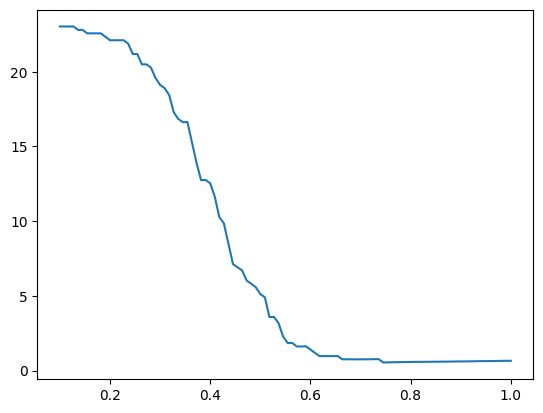

In [292]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(epsilons, accs)
